In [1]:
from tradeModul.csv_loader import load_data, save_data
from tradeModul.mvccsql import MVCCSQL
from tradeModul.analysis import plot_pairplot, plot_dependency_graph
import pandas as pd
# Увеличить максимальное количество отображаемых столбцов
pd.set_option('display.max_columns', None)  # или число, например 50
# Увеличить ширину строки вывода
pd.set_option('display.width', 1000)
# Увеличить максимальное количество символов в ячейке
pd.set_option('display.max_colwidth', None)



In [2]:

#  -------------------------- Attention! ----------------------------------------
# The original data "Motor Vehicle Collisions - Crashes" is on the website https://catalog.data.gov/dataset/motor-vehicle-collisions-crashes
# The dataset contains approximately 2 million records.
# For the example, only the first 100,000 are used.
# df = load_data("/home/gr/Downloads/DataSets/Motor Vehicle Collisions - Crashes/Motor_Vehicle_Collisions_-_Crashes.csv", 100000)

df = load_data("Crashes.csv", 100000)
# save_data(df, "Crashes.csv")

Данные успешно загружены из 'Crashes.csv'. Форма: (100000, 29)


In [3]:
sql = MVCCSQL()

In [4]:

# sql.delete_all_table()
# sql.drop_all_table()
sql.create_table()

In [5]:
# sql.insert_data(df)
sql.insert_data_fast(df)

 Начинаем вставку 100000 записей...
 Кэш загружен: улицы(29753), факторы(55), типы ТС(590)
index: 0
index: 99999
 Собрано 0 записей для вставки. Пропущено: 100000
 Кэш загружен: улицы(29753), факторы(55), типы ТС(590)


In [6]:
print("\n 1. Общее количество ДТП")
print(sql.sql_to_df("SELECT COUNT(*) AS total_crashes FROM crashes;"))

print("\n 2. Общее количество пострадавших и погибших людей")
print(sql.sql_to_df("""
    SELECT
        SUM(number_of_persons_injured) AS total_injured,
        SUM(number_of_persons_killed) AS total_killed
    FROM crashes;
"""))

print("\n 3. Максимальное количество погибших в одном ДТП")
print(sql.sql_to_df("SELECT MAX(number_of_persons_killed) AS max_persons_killed_in_one_crash FROM crashes;"))


print("\n 4. Максимальное количество погибших велосипедистов в одном ДТП")
print(sql.sql_to_df("SELECT MAX(number_of_cyclist_killed) AS max_cyclists_killed_in_one_crash FROM crashes;"))

print("\n 5. Количество ДТП с участием мотоциклистов")
print(sql.sql_to_df("""
    SELECT COUNT(*) AS crashes_with_motorists
    FROM crashes
    WHERE number_of_motorist_injured > 0 OR number_of_motorist_killed > 0;
"""))

print("\n 6. Топ-5 районов по количеству погибших")
print(sql.sql_to_df("""
    SELECT
        borough,
        SUM(number_of_persons_killed) AS total_deaths
    FROM crashes
    WHERE borough IS NOT NULL
    GROUP BY borough
    ORDER BY total_deaths DESC
    LIMIT 5;
"""))

print("\n 7. Процент смертельных ДТП")
print(sql.sql_to_df("""
    SELECT
        (COUNT(CASE WHEN number_of_persons_killed > 0 THEN 1 END) * 100.0 / COUNT(*)) AS fatal_crash_percentage
    FROM crashes;
"""))


 1. Общее количество ДТП
   total_crashes
0         100000

 2. Общее количество пострадавших и погибших людей
   total_injured  total_killed
0          48286           270

 3. Максимальное количество погибших в одном ДТП
   max_persons_killed_in_one_crash
0                                3

 4. Максимальное количество погибших велосипедистов в одном ДТП
   max_cyclists_killed_in_one_crash
0                                 1

 5. Количество ДТП с участием мотоциклистов
   crashes_with_motorists
0                   22661

 6. Топ-5 районов по количеству погибших
         borough  total_deaths
0       BROOKLYN            49
1         QUEENS            29
2          BRONX            28
3      MANHATTAN            25
4  STATEN ISLAND             3

 7. Процент смертельных ДТП
   fatal_crash_percentage
0                   0.262


In [7]:

df = sql.sql_to_df("SELECT crash_date, crash_time, number_of_persons_injured, number_of_persons_killed FROM crashes;")
# Преобразуем дату и время в datetime
df['crash_datetime'] = pd.to_datetime(df['crash_date'] + ' ' + df['crash_time'], format='%m/%d/%Y %H:%M')

print(df.head())

   crash_date crash_time  number_of_persons_injured  number_of_persons_killed      crash_datetime
0  09/11/2021       2:39                          2                         0 2021-09-11 02:39:00
1  03/26/2022      11:45                          1                         0 2022-03-26 11:45:00
2  11/01/2023       1:29                          1                         0 2023-11-01 01:29:00
3  06/29/2022       6:55                          0                         0 2022-06-29 06:55:00
4  09/21/2022      13:21                          0                         0 2022-09-21 13:21:00


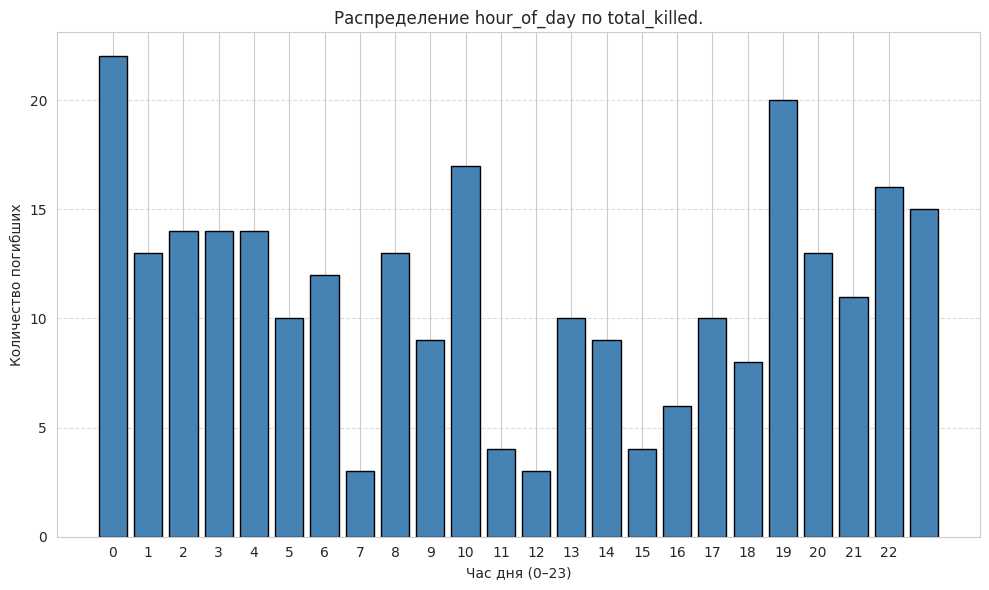

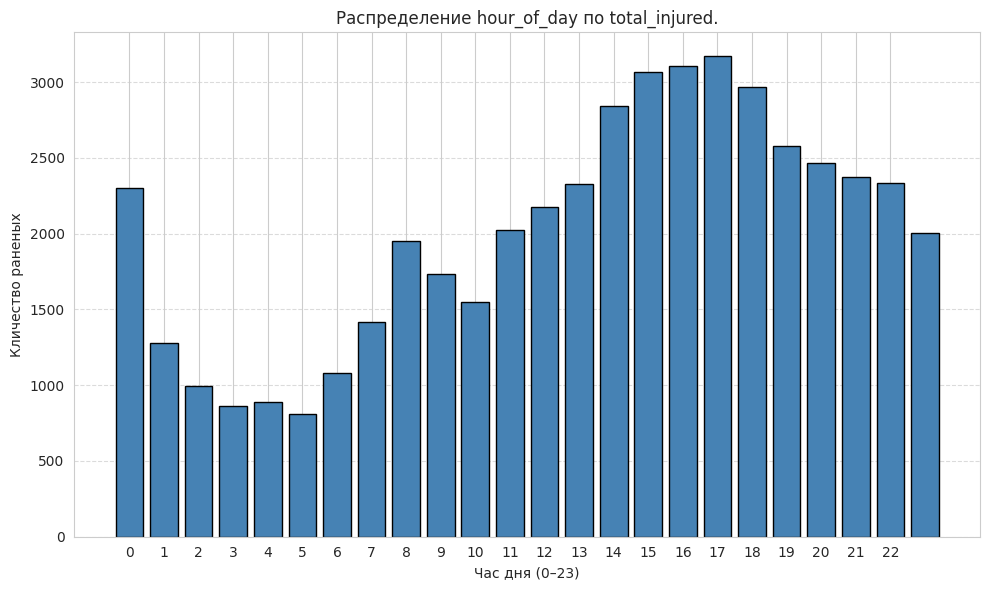

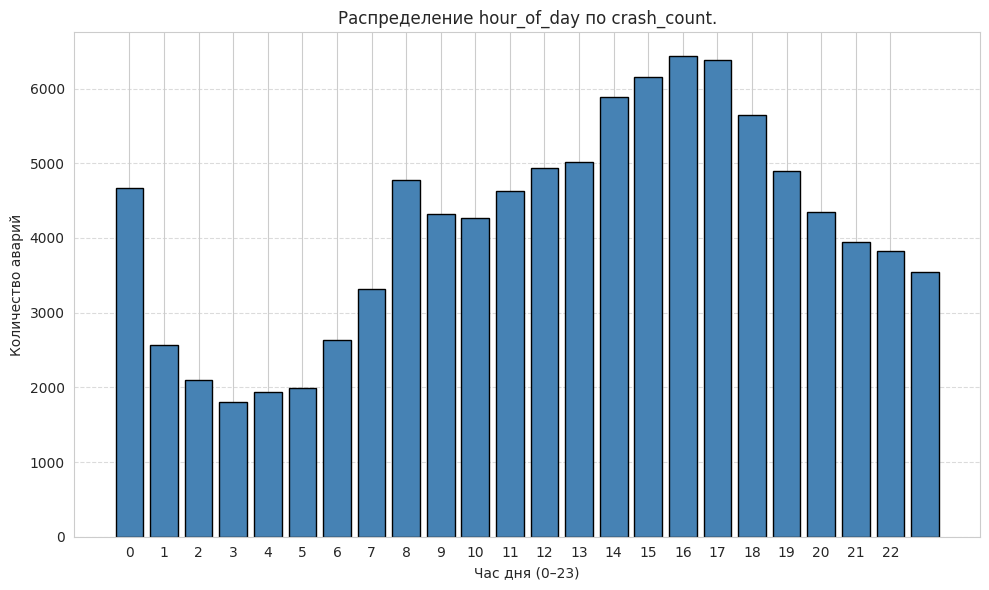

In [8]:

# Группируем по часу суток и суммируем количество погибших
df_hourly_killed = df.groupby(df['crash_datetime'].dt.hour)['number_of_persons_killed'].sum().reset_index()
df_hourly_killed.rename(columns={'crash_datetime': 'hour_of_day', 'number_of_persons_killed': 'total_killed'}, inplace=True)
plot_dependency_graph(df_hourly_killed, 'hour_of_day', 'total_killed', 'Час дня (0–23)', 'Количество погибших')

# Группируем по часу и суммируем количество раненых
df_hourly_injured = df.groupby(df['crash_datetime'].dt.hour)['number_of_persons_injured'].sum().reset_index()
df_hourly_injured.rename(columns={'crash_datetime': 'hour_of_day', 'number_of_persons_injured': 'total_injured'}, inplace=True)
plot_dependency_graph(df_hourly_injured, 'hour_of_day', 'total_injured', 'Час дня (0–23)', 'Кличество раненых')

# Группируем по часу и суммируем количество аварий
df_hourly = df.groupby(df['crash_datetime'].dt.hour).size().reset_index(name='crash_count')
df_hourly.rename(columns={'crash_datetime': 'hour_of_day'}, inplace=True)
plot_dependency_graph(df_hourly, 'hour_of_day', 'crash_count', 'Час дня (0–23)', 'Количество аварий')


<Figure size 1200x1000 with 0 Axes>

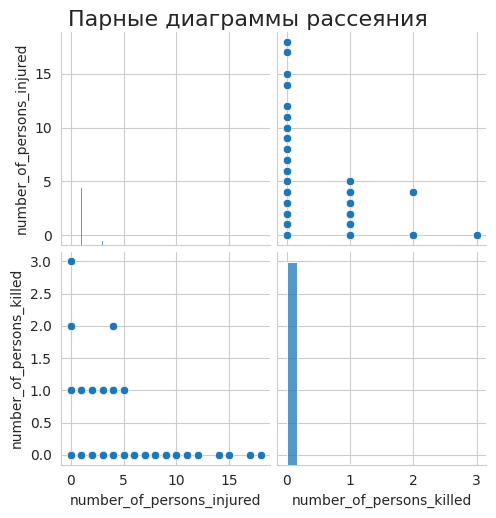

In [9]:
plot_pairplot(df)